In [68]:
import json
import os
import pandas as pd
import torch
import pickle 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data Cleaning

In [69]:
with open('Y.json', 'r') as file:
    y = json.load(file)

In [70]:
dt = {}
all_cols = None
y_list = []
for file in os.listdir('filtered_dt_428'):
    if file.endswith('.csv'):
        k = file.split('_')[0]
        if k in y:
            dt[k] = pd.read_csv(os.path.join('filtered_dt_428', file))
            dt[k] = dt[k].loc[:, ~dt[k].columns.duplicated()]
            dt[k] = dt[k].reindex(sorted(dt[k].columns), axis=1)
            y_list.append(y[k])

In [71]:
dt.keys()

dict_keys(['SBBP', 'WTT', 'RLGY', 'UNFI', 'JAN', 'URS', 'HROW', 'COV', 'DSNY', 'VTSS', 'DNDN', 'GEOS', 'XRX', 'JCS', 'ARTX', 'MRAM', 'JACK', 'SEAS', 'AFFX', 'NP', 'VSYS', 'SPGI', 'LCAV', 'W', 'SLH', 'SSD', 'ROCK', 'SNBR', 'CTAS', 'ZBRA', 'LL', 'MPSX', 'GLUX', 'BLFS', 'CVO', 'GAXY', 'APH', 'SCOR', 'RHI', 'PTEN', 'JOUT', 'CTS', 'NYNY', 'HZNP', 'BURL', 'SPWR', 'CYNO', 'QUMU', 'HIBB', 'EXAC', 'UPLD', 'HD', 'MTDR', 'OESX', 'VMD', 'WH', 'HUN', 'PLAB', 'OOMA', 'PEP', 'INTC', 'SWM', 'MYDX', 'UNVR', 'GSB', 'CULP', 'PHAT', 'NLS', 'WGBS', 'PKT', 'BRID', 'ACTA', 'CTIB', 'VSLR', 'CYTX', 'NVOS', 'SCWX', 'CST', 'ZIPR', 'ALRM', 'OLLI', 'RTIX', 'LECO', 'TCRR', 'TEG', 'SLQT', 'UNP', 'OSW', 'AMOT', 'DDD', 'WAT', 'ARAY', 'INSE', 'PAYC', 'VWR', 'RS', 'FTLF', 'RCKY', 'ADSK', 'DIN', 'ITT', 'CUDA', 'STXS', 'RTK', 'SFIX', 'TZOO', 'ANV', 'WNC', 'DKS', 'MTSN', 'TCS', 'PATI', 'ALJ', 'VICR', 'CBPO', 'CSLT', 'VZ', 'EVK', 'QNST', 'RILY', 'MLI', 'RKUS', 'CISN', 'TG', 'HIL', 'EVRG', 'CRSP', 'GNTX', 'KBALB', 'ZAYO', 'J

In [72]:
def parse_columns(df):
    """
    Function to parse column names and remove the {ticker}: prefix.
    """
    new_columns = []
    for col in df.columns:
        if ":" in col:
            ticker, real_col_name = col.split(":")
            new_columns.append(real_col_name)
        else:
            new_columns.append(col)
    return new_columns

# Get the union of all column names across the DataFrames
all_cols = set().union(*[set(parse_columns(df)) for df in dt.values()])
list(all_cols)

# Update the column names for each DataFrame
for k in list(dt.keys()):
    dt[k].columns = parse_columns(dt[k])
    try:
        dt[k] = dt[k].reindex(columns=all_cols, fill_value=0)
    except Exception as e:
        print(k, e)

In [73]:
# nodes
padded_tensors = []
max_length = 7
for df in dt.values():
    num_cols = df.columns[df.dtypes != 'object']
    df = df[num_cols]
    # get first 7 rows
    padded_tensor = torch.tensor(df.iloc[-7:].values.tolist())
    # padded_tensor = torch.nn.functional.pad(padded_tensor, (0, 0, 0, max_length - len(df)))
    padded_tensors.append(padded_tensor)
# E = adj.repeat(len(dt), max_length, 1, 1)

In [74]:
# T x batch size x features
X = torch.stack(padded_tensors, dim=1)

mean_tensor = torch.mean(X, dim=(0, 1), keepdim=True)
std_tensor = torch.std(X, dim=(0, 1), unbiased=False, keepdim=True)
X = (X - mean_tensor) / std_tensor
X = X.permute(1, 0, 2)
y = y_list

# Model - Raw Data

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
n_features = X.shape[2]  # Number of features

In [77]:
# Create TensorDataset
dataset = TensorDataset(X, torch.tensor(y))

# Split the data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [78]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(1, batch_size, self.hidden_size).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.fc(hn.view(-1, self.hidden_size))
        return out

In [79]:
input_size = X.shape[2]  # Number of features
output_size = 1  # Single output for price prediction
hidden_size = 64  # Number of hidden units in the LSTM

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [80]:
epochs = 500

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training loop
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset) * 10 
    if epoch % 50 == 0:
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Siz

Epoch: 1, Train Loss: 2.8321, Val Loss: 0.0256
Epoch: 51, Train Loss: 2.6520, Val Loss: 0.0213
Epoch: 101, Train Loss: 2.6445, Val Loss: 0.0210
Epoch: 151, Train Loss: 2.6430, Val Loss: 0.0212
Epoch: 201, Train Loss: 2.6431, Val Loss: 0.0212
Epoch: 251, Train Loss: 2.6429, Val Loss: 0.0211
Epoch: 301, Train Loss: 2.6434, Val Loss: 0.0218
Epoch: 351, Train Loss: 2.6431, Val Loss: 0.0213
Epoch: 401, Train Loss: 2.6425, Val Loss: 0.0214
Epoch: 451, Train Loss: 2.6431, Val Loss: 0.0211


In [81]:
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if loss.item() < 50 or torch.any(outputs > 50):
            val_loss += loss.item() * inputs.size(0)

val_loss /= len(val_dataset)
val_loss

0.2102630215946028

In [82]:
torch.cat([x.squeeze(1) for x in preds], dim=0).std()

tensor(0.0225)

# Model - PCA Data

In [83]:
X_pca = X.reshape(-1, X.shape[-1])

pca = PCA().fit(X_pca)

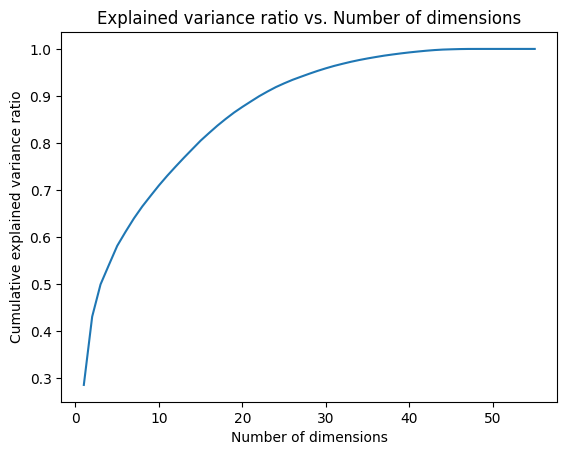

Optimal number of dimensions: 15


In [84]:
evr = pca.explained_variance_ratio_
# Calculate the cumulative sum of the explained variance ratio
cumulative_var_ratio = np.cumsum(evr)

# Plot the cumulative sum of the explained variance ratio
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio)
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Explained variance ratio vs. Number of dimensions')
plt.show()

# Find the optimal number of dimensions
optimal_dim = np.argmax(cumulative_var_ratio >= 0.80) + 1
print('Optimal number of dimensions:', optimal_dim)


In [85]:
pca = PCA(n_components=optimal_dim)
pca = pca.fit(X_pca)

In [86]:
X_compressed = torch.zeros(X.shape[0], X.shape[1], optimal_dim)
for k in range(X.shape[0]):
    X_compressed[k, :, :] = torch.tensor(pca.transform(X[k, :, :]))

X_compressed_val = torch.zeros(X_val.shape[0], X_val.shape[1], optimal_dim)
for k in range(X_val.shape[0]):
    X_compressed_val[k, :, :] = torch.tensor(pca.transform(X[k, :, :]))

In [87]:
# Create TensorDataset
dataset = TensorDataset(X_compressed, torch.tensor(y))

# Split the data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [88]:
input_size = X_compressed.shape[2]  # Number of features
output_size = 1  # Single output for price prediction
hidden_size = 64  # Number of hidden units in the LSTM

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [89]:
epochs = 500

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training loop
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Siz

Epoch: 1, Train Loss: 0.9311, Val Loss: 8.8665
Epoch: 11, Train Loss: 0.4978, Val Loss: 8.8038
Epoch: 21, Train Loss: 0.4952, Val Loss: 8.7852
Epoch: 31, Train Loss: 0.4973, Val Loss: 8.8108
Epoch: 41, Train Loss: 0.4972, Val Loss: 8.7886
Epoch: 51, Train Loss: 0.4962, Val Loss: 8.8060
Epoch: 61, Train Loss: 0.4956, Val Loss: 8.7964
Epoch: 71, Train Loss: 0.4955, Val Loss: 8.8019
Epoch: 81, Train Loss: 0.4955, Val Loss: 8.7956
Epoch: 91, Train Loss: 0.4955, Val Loss: 8.7975
Epoch: 101, Train Loss: 0.4958, Val Loss: 8.8150
Epoch: 111, Train Loss: 0.4968, Val Loss: 8.7864
Epoch: 121, Train Loss: 0.4961, Val Loss: 8.8011
Epoch: 131, Train Loss: 0.4959, Val Loss: 8.7905
Epoch: 141, Train Loss: 0.4970, Val Loss: 8.7859
Epoch: 151, Train Loss: 0.4969, Val Loss: 8.7981
Epoch: 161, Train Loss: 0.4965, Val Loss: 8.8130
Epoch: 171, Train Loss: 0.4955, Val Loss: 8.8003
Epoch: 181, Train Loss: 0.4953, Val Loss: 8.8098
Epoch: 191, Train Loss: 0.4954, Val Loss: 8.7978
Epoch: 201, Train Loss: 0.4957,

In [90]:
X_compressed_val.shape

torch.Size([466, 7, 15])

In [91]:
model.eval()
preds = []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        preds.append(outputs)
        loss = criterion(outputs, targets)
        if loss.item() < 50 or torch.any(outputs > 50):
            val_loss += loss.item() * inputs.size(0)

val_loss /= len(val_dataset)
val_loss

0.1462570931843771

In [92]:
torch.cat([x.squeeze(1) for x in preds], dim=0).std()

tensor(0.0206)